### Creating a word embedding from scratch

In [1]:
import re
import numpy as np

def create_unique_word_dict(text:list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict    

def text_preprocessing(
    text:list,
    punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
    stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will']
    )->list:
    """
    A method to preproces text
    """
    for x in text.lower(): 
        if x in punctuations: 
            text = text.replace(x, "")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list 
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x!='']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text

# Functions to find the most similar word 
def euclidean(vec1:np.array, vec2:np.array) -> float:
    """
    A function to calculate the euclidean distance between two vectors
    """
    return np.sqrt(np.sum((vec1 - vec2)**2))

def find_similar(word:str, embedding_dict:dict, top_n=10)->list:
    """
    A method to find the most similar word based on the learnt embeddings
    """
    dist_dict = {}
    word_vector = embedding_dict.get(word, [])
    if len(word_vector) > 0:
        for key, value in embedding_dict.items():
            if key!=word:
                dist = euclidean(word_vector, value)
                dist_dict.update({
                    key: dist
                })

        return sorted(dist_dict.items(), key=lambda x: x[1])[0:top_n]    

In [2]:
import itertools
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm

# Drawing the embeddings
import matplotlib.pyplot as plt

# Deep learning: 
from keras.models import Input, Model
from keras.layers import Dense

from scipy import sparse

Using TensorFlow backend.
/Users/pg100121/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/pg100121/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/pg100121/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/pg100121/opt/anaconda3/lib/p

In [3]:
# Reading the text from the input folder
texts = pd.read_csv('data/sample.csv')
texts = [x for x in texts['text']]


# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

In [4]:
for text in texts:

    # Cleaning the text
    text = text_preprocessing(text)
    
    # Appending to the all text list
    all_text += text 
    print(all_text)

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

unique_word_dict = create_unique_word_dict(all_text)

['future', 'king', 'prince']
['future', 'king', 'prince', 'daughter', 'princess']
['future', 'king', 'prince', 'daughter', 'princess', 'son', 'prince']
['future', 'king', 'prince', 'daughter', 'princess', 'son', 'prince', 'only', 'man', 'can', 'king']
['future', 'king', 'prince', 'daughter', 'princess', 'son', 'prince', 'only', 'man', 'can', 'king', 'only', 'woman', 'can', 'queen']
['future', 'king', 'prince', 'daughter', 'princess', 'son', 'prince', 'only', 'man', 'can', 'king', 'only', 'woman', 'can', 'queen', 'princess', 'queen']
['future', 'king', 'prince', 'daughter', 'princess', 'son', 'prince', 'only', 'man', 'can', 'king', 'only', 'woman', 'can', 'queen', 'princess', 'queen', 'queen', 'king', 'rule', 'realm']
['future', 'king', 'prince', 'daughter', 'princess', 'son', 'prince', 'only', 'man', 'can', 'king', 'only', 'woman', 'can', 'queen', 'princess', 'queen', 'queen', 'king', 'rule', 'realm', 'prince', 'strong', 'man']
['future', 'king', 'prince', 'daughter', 'princess', 'son'

In [5]:
# Defining the number of features (unique words)
n_words = len(unique_word_dict)

# Getting all the unique words 
words = list(unique_word_dict.keys())

# Creating the X and Y matrices using one hot encoding
X = []
Y = []

In [6]:
for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    # Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

84it [00:00, 158774.91it/s]


In [7]:
# Converting the matrices into a sparse format because the vast majority of the data are 0s
X = sparse.csr_matrix(X)
Y = sparse.csr_matrix(Y)

# Defining the size of the embedding
embed_size = 2

In [8]:
# Defining the neural network
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Optimizing the network weights
model.fit(
    x=X, 
    y=Y, 
    batch_size=256,
    epochs=1000
    )


Epoch 1/1000
84/84 [==============================] - 0s 930us/step - loss: 3.0453
Epoch 2/1000
84/84 [==============================] - 0s 13us/step - loss: 3.0443
Epoch 3/1000
84/84 [==============================] - 0s 12us/step - loss: 3.0432
Epoch 4/1000
84/84 [==============================] - 0s 13us/step - loss: 3.0422
Epoch 5/1000
84/84 [==============================] - 0s 14us/step - loss: 3.0412
Epoch 6/1000
84/84 [==============================] - 0s 13us/step - loss: 3.0401
Epoch 7/1000
84/84 [==============================] - 0s 14us/step - loss: 3.0391
Epoch 8/1000
84/84 [==============================] - 0s 14us/step - loss: 3.0381
Epoch 9/1000
84/84 [==============================] - 0s 14us/step - loss: 3.0370
Epoch 10/1000
84/84 [==============================] - 0s 15us/step - loss: 3.0360
Epoch 11/1000
84/84 [==============================] - 0s 13us/step - loss: 3.0350
Epoch 12/1000
84/84 [==============================] - 0s 13us/step - loss: 3.0340
Epoch 13/10

Epoch 98/1000
84/84 [==============================] - 0s 19us/step - loss: 2.9486
Epoch 99/1000
84/84 [==============================] - 0s 17us/step - loss: 2.9475
Epoch 100/1000
84/84 [==============================] - 0s 18us/step - loss: 2.9465
Epoch 101/1000
84/84 [==============================] - 0s 17us/step - loss: 2.9455
Epoch 102/1000
84/84 [==============================] - 0s 16us/step - loss: 2.9445
Epoch 103/1000
84/84 [==============================] - 0s 18us/step - loss: 2.9435
Epoch 104/1000
84/84 [==============================] - 0s 16us/step - loss: 2.9425
Epoch 105/1000
84/84 [==============================] - 0s 15us/step - loss: 2.9415
Epoch 106/1000
84/84 [==============================] - 0s 21us/step - loss: 2.9405
Epoch 107/1000
84/84 [==============================] - 0s 15us/step - loss: 2.9395
Epoch 108/1000
84/84 [==============================] - 0s 18us/step - loss: 2.9385
Epoch 109/1000
84/84 [==============================] - 0s 21us/step - loss: 2

Epoch 196/1000
84/84 [==============================] - 0s 14us/step - loss: 2.8486
Epoch 197/1000
84/84 [==============================] - 0s 14us/step - loss: 2.8476
Epoch 198/1000
84/84 [==============================] - 0s 13us/step - loss: 2.8466
Epoch 199/1000
84/84 [==============================] - 0s 13us/step - loss: 2.8456
Epoch 200/1000
84/84 [==============================] - 0s 15us/step - loss: 2.8446
Epoch 201/1000
84/84 [==============================] - 0s 15us/step - loss: 2.8436
Epoch 202/1000
84/84 [==============================] - 0s 16us/step - loss: 2.8426
Epoch 203/1000
84/84 [==============================] - 0s 17us/step - loss: 2.8416
Epoch 204/1000
84/84 [==============================] - 0s 14us/step - loss: 2.8406
Epoch 205/1000
84/84 [==============================] - 0s 18us/step - loss: 2.8396
Epoch 206/1000
84/84 [==============================] - 0s 16us/step - loss: 2.8386
Epoch 207/1000
84/84 [==============================] - 0s 15us/step - loss:

Epoch 294/1000
84/84 [==============================] - 0s 15us/step - loss: 2.7556
Epoch 295/1000
84/84 [==============================] - 0s 14us/step - loss: 2.7547
Epoch 296/1000
84/84 [==============================] - 0s 15us/step - loss: 2.7538
Epoch 297/1000
84/84 [==============================] - 0s 17us/step - loss: 2.7529
Epoch 298/1000
84/84 [==============================] - 0s 15us/step - loss: 2.7521
Epoch 299/1000
84/84 [==============================] - 0s 16us/step - loss: 2.7512
Epoch 300/1000
84/84 [==============================] - 0s 16us/step - loss: 2.7503
Epoch 301/1000
84/84 [==============================] - 0s 17us/step - loss: 2.7494
Epoch 302/1000
84/84 [==============================] - 0s 20us/step - loss: 2.7485
Epoch 303/1000
84/84 [==============================] - 0s 16us/step - loss: 2.7476
Epoch 304/1000
84/84 [==============================] - 0s 14us/step - loss: 2.7467
Epoch 305/1000
84/84 [==============================] - 0s 13us/step - loss:

Epoch 392/1000
84/84 [==============================] - 0s 13us/step - loss: 2.6717
Epoch 393/1000
84/84 [==============================] - 0s 15us/step - loss: 2.6708
Epoch 394/1000
84/84 [==============================] - 0s 15us/step - loss: 2.6700
Epoch 395/1000
84/84 [==============================] - 0s 14us/step - loss: 2.6692
Epoch 396/1000
84/84 [==============================] - 0s 16us/step - loss: 2.6684
Epoch 397/1000
84/84 [==============================] - 0s 20us/step - loss: 2.6676
Epoch 398/1000
84/84 [==============================] - 0s 17us/step - loss: 2.6667
Epoch 399/1000
84/84 [==============================] - 0s 17us/step - loss: 2.6659
Epoch 400/1000
84/84 [==============================] - 0s 17us/step - loss: 2.6651
Epoch 401/1000
84/84 [==============================] - 0s 16us/step - loss: 2.6643
Epoch 402/1000
84/84 [==============================] - 0s 15us/step - loss: 2.6635
Epoch 403/1000
84/84 [==============================] - 0s 17us/step - loss:

Epoch 490/1000
84/84 [==============================] - 0s 18us/step - loss: 2.5943
Epoch 491/1000
84/84 [==============================] - 0s 18us/step - loss: 2.5935
Epoch 492/1000
84/84 [==============================] - 0s 15us/step - loss: 2.5928
Epoch 493/1000
84/84 [==============================] - 0s 14us/step - loss: 2.5920
Epoch 494/1000
84/84 [==============================] - 0s 20us/step - loss: 2.5913
Epoch 495/1000
84/84 [==============================] - 0s 26us/step - loss: 2.5905
Epoch 496/1000
84/84 [==============================] - 0s 22us/step - loss: 2.5898
Epoch 497/1000
84/84 [==============================] - 0s 21us/step - loss: 2.5890
Epoch 498/1000
84/84 [==============================] - 0s 24us/step - loss: 2.5883
Epoch 499/1000
84/84 [==============================] - 0s 23us/step - loss: 2.5875
Epoch 500/1000
84/84 [==============================] - 0s 24us/step - loss: 2.5868
Epoch 501/1000
84/84 [==============================] - 0s 25us/step - loss:

Epoch 588/1000
84/84 [==============================] - 0s 18us/step - loss: 2.5249
Epoch 589/1000
84/84 [==============================] - 0s 15us/step - loss: 2.5243
Epoch 590/1000
84/84 [==============================] - 0s 14us/step - loss: 2.5236
Epoch 591/1000
84/84 [==============================] - 0s 15us/step - loss: 2.5230
Epoch 592/1000
84/84 [==============================] - 0s 19us/step - loss: 2.5223
Epoch 593/1000
84/84 [==============================] - 0s 14us/step - loss: 2.5217
Epoch 594/1000
84/84 [==============================] - 0s 14us/step - loss: 2.5210
Epoch 595/1000
84/84 [==============================] - 0s 18us/step - loss: 2.5203
Epoch 596/1000
84/84 [==============================] - 0s 14us/step - loss: 2.5197
Epoch 597/1000
84/84 [==============================] - 0s 15us/step - loss: 2.5190
Epoch 598/1000
84/84 [==============================] - 0s 15us/step - loss: 2.5184
Epoch 599/1000
84/84 [==============================] - 0s 13us/step - loss:

Epoch 686/1000
84/84 [==============================] - 0s 13us/step - loss: 2.4656
Epoch 687/1000
84/84 [==============================] - 0s 14us/step - loss: 2.4651
Epoch 688/1000
84/84 [==============================] - 0s 13us/step - loss: 2.4645
Epoch 689/1000
84/84 [==============================] - 0s 13us/step - loss: 2.4640
Epoch 690/1000
84/84 [==============================] - 0s 16us/step - loss: 2.4634
Epoch 691/1000
84/84 [==============================] - 0s 16us/step - loss: 2.4629
Epoch 692/1000
84/84 [==============================] - 0s 14us/step - loss: 2.4623
Epoch 693/1000
84/84 [==============================] - 0s 16us/step - loss: 2.4618
Epoch 694/1000
84/84 [==============================] - 0s 15us/step - loss: 2.4612
Epoch 695/1000
84/84 [==============================] - 0s 13us/step - loss: 2.4607
Epoch 696/1000
84/84 [==============================] - 0s 16us/step - loss: 2.4601
Epoch 697/1000
84/84 [==============================] - 0s 14us/step - loss:

Epoch 784/1000
84/84 [==============================] - 0s 14us/step - loss: 2.4162
Epoch 785/1000
84/84 [==============================] - 0s 14us/step - loss: 2.4157
Epoch 786/1000
84/84 [==============================] - 0s 17us/step - loss: 2.4152
Epoch 787/1000
84/84 [==============================] - 0s 14us/step - loss: 2.4148
Epoch 788/1000
84/84 [==============================] - 0s 15us/step - loss: 2.4143
Epoch 789/1000
84/84 [==============================] - 0s 14us/step - loss: 2.4139
Epoch 790/1000
84/84 [==============================] - 0s 15us/step - loss: 2.4134
Epoch 791/1000
84/84 [==============================] - 0s 14us/step - loss: 2.4130
Epoch 792/1000
84/84 [==============================] - 0s 16us/step - loss: 2.4125
Epoch 793/1000
84/84 [==============================] - 0s 15us/step - loss: 2.4121
Epoch 794/1000
84/84 [==============================] - 0s 14us/step - loss: 2.4116
Epoch 795/1000
84/84 [==============================] - 0s 15us/step - loss:

Epoch 882/1000
84/84 [==============================] - 0s 15us/step - loss: 2.3749
Epoch 883/1000
84/84 [==============================] - 0s 15us/step - loss: 2.3745
Epoch 884/1000
84/84 [==============================] - 0s 15us/step - loss: 2.3741
Epoch 885/1000
84/84 [==============================] - 0s 13us/step - loss: 2.3737
Epoch 886/1000
84/84 [==============================] - 0s 16us/step - loss: 2.3733
Epoch 887/1000
84/84 [==============================] - 0s 14us/step - loss: 2.3729
Epoch 888/1000
84/84 [==============================] - 0s 13us/step - loss: 2.3726
Epoch 889/1000
84/84 [==============================] - 0s 14us/step - loss: 2.3722
Epoch 890/1000
84/84 [==============================] - 0s 15us/step - loss: 2.3718
Epoch 891/1000
84/84 [==============================] - 0s 14us/step - loss: 2.3714
Epoch 892/1000
84/84 [==============================] - 0s 13us/step - loss: 2.3710
Epoch 893/1000
84/84 [==============================] - 0s 17us/step - loss:

Epoch 980/1000
84/84 [==============================] - 0s 14us/step - loss: 2.3398
Epoch 981/1000
84/84 [==============================] - 0s 15us/step - loss: 2.3395
Epoch 982/1000
84/84 [==============================] - 0s 13us/step - loss: 2.3392
Epoch 983/1000
84/84 [==============================] - 0s 14us/step - loss: 2.3388
Epoch 984/1000
84/84 [==============================] - 0s 15us/step - loss: 2.3385
Epoch 985/1000
84/84 [==============================] - 0s 14us/step - loss: 2.3382
Epoch 986/1000
84/84 [==============================] - 0s 13us/step - loss: 2.3379
Epoch 987/1000
84/84 [==============================] - 0s 13us/step - loss: 2.3375
Epoch 988/1000
84/84 [==============================] - 0s 16us/step - loss: 2.3372
Epoch 989/1000
84/84 [==============================] - 0s 15us/step - loss: 2.3369
Epoch 990/1000
84/84 [==============================] - 0s 14us/step - loss: 2.3366
Epoch 991/1000
84/84 [==============================] - 0s 14us/step - loss:

In [9]:
# Obtaining the weights from the neural network. 
# These are the so called word embeddings

# The input layer 
weights = model.get_weights()[0]

# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })


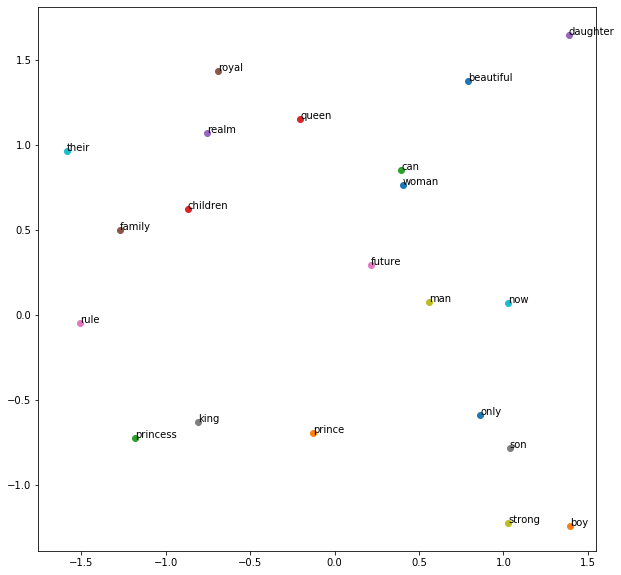

In [12]:
# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in list(unique_word_dict.keys()):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))       

In [13]:
# Saving the embedding vector to a txt file
try:
    os.mkdir(f'{os.getcwd()}\\output')        
except Exception as e:
    print(f'Cannot create output folder: {e}')

with open(f'{os.getcwd()}\\output\\embedding.txt', 'w') as f:
    for key, value in embedding_dict.items():
        try:
            f.write(f'{key}: {value}\n')   
        except Exception as e:
            print(f'Cannot write word {key} to dict: {e}') 

Cannot create output folder: [Errno 17] File exists: '/Users/pg100121/projects/flafoo_experiments\\output'
